# 3. Autoencoders (AE) en MNIST

**Importación de módulos necesarios**

In [15]:
from keras.datasets import mnist
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras.optimizers import SGD, adadelta
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import time

**3.0 Creación de conjuntos de datos a utilizar**

En primer lugar, se crean los conjuntos de datos a ser utilizados en la resolución del problema. Para ello, el dataset completo de imágenes es obtenido desde el repositorio de *keras*. Posteriormente, las matrices que contienen las imágenes, *x_train* y *x_test*, son escaladas en base a la intensidad máxima de píxel y luego reorganizadas como un vector cada una.

Además, se crea el conjunto de validación que será usado más adelante, extrayendo para ello los últimos 5.000 registros del conjunto de entrenamiento.

In [16]:
# Se cargan conjutos de entrenamiento y de prueba
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Se normalizan conjuntos de datos en base a intensidad máxima de pixel
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Se transforman las imágenes de ambos conjuntos a vectores
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Se define conjunto de validación y se reestructura conjunto de entrenamiento
x_val = x_train[5000:, :]
x_train = x_train[:5000, :]
y_val = y_train[5000:]
y_train = y_train[:5000]

# 3.1 Reducción de dimensionalidad

En esta sección, se hará uso de diversos AE's como reductores de dimensionalidad, esperando mejorar el rendimiento de modelos convolucionales, los cuales recibirán como inputs las imágenes "reducidas" y serán entrenados para construir un clasificador de dígitos. 

**3.1.1 AE con una capa escondida**

Se comienza construyendo un AE simple, compuesto únicamente por una capa oculta (enconder) y una capa de salida (decoder). En principio, el enconder utilizará la función de activación sigmoide, para luego experimentar con ReLU, al igual que el decoder. Se usará *adadelta* como método de entrenamiento y *binary crossentropy* como función de pérdida. Para la implementación del AE, se construye la función *simple_AE*, que recibe como parámetro el nivel de compresión deseado y la función de activación del encoder. Como salida, se generan archivos que registran el porcentaje de compresión obtenido y el error de reconstrucción de cada configuración.

El enconder estará integrado por d' neuronas, con d' en {2, 8, 32, 64}. Esto quiere decir que el input original, de 784 dimensiones, será comprimido en un vector de d' dimensiones.

El decoder en cambio, estára compuesto, naturalmente, por 784 neuronas, pues se busca restaurar la estructura inicial del input recibido.

In [17]:
# Implementación de función simple_AE; d_ : compresión deseada; act_func: función de activación encoder
def simple_AE(d_, act_functions):
    # Se determina el tipo de input a ser recibido por el AE
    input_img = Input(shape=(784,))
    # "encoded" es la versión codificada del input
    encoded = Dense(d_, activation=act_functions[0])(input_img)
    # "decoded" es la reconstrucción del input codificado
    decoded = Dense(784, activation=act_functions[1])(encoded)
    # Se genera AE a partir de capas anteriores, el cual mapea un input hacia su reconstrucción
    autoencoder = Model(input=input_img, output=decoded)
    # Se definen método de entrenamiento y función de pérdida
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    # Se entrena AE
    history = autoencoder.fit(x_train, x_train,
              epochs=50,
              batch_size=256,
              shuffle=True,
              verbose=0,
              validation_data=(x_val, x_val))
    # Se guardan porcentaje de compresión y error de reconstrucción en un archivo
    autoencoder.save('basic_autoenconder_784x' + str(d_) + act_functions[0] + '_' + act_functions[1] + '.h5')

Así, se procede a generar AE's para d' dimensiones y utilizando la función ReLU y/o sigmoide en el enconder y/o el decoder.

In [18]:
# Valores posibles para la dimensión del input comprimido
dimensions = [2, 8, 32, 64]
# Funciones de activación posibles
activations = [('sigmoid', 'sigmoid'), ('relu', 'sigmoid'), ('sigmoid', 'relu')]

In [19]:
warnings.filterwarnings('ignore')

# Se generan todos los AE's posibles
for dimension in dimensions:
    for activation in activations:
        simple_AE(dimension, activation)

Generados los archivos, se procede a leerlos para determinar el rendimiento de cada una de las configuraciones. 

In [32]:
for activation in activations:
    print('Encoder: ' + activation[0] + ' | ' + 'Decoder: ' + activation[1])
    for dimension in dimensions:
        autoencoder = load_model('basic_autoenconder_784x' + str(dimension) + activation[0] + '_' + activation[1] + '.h5')
        # Se determina nivel de compresión
        compression = 784. / float(dimension)
        
        # Se determina error de reconstrucción
        x_pred = autoencoder.predict(x_test)
        m,n = x_test.shape
        aux = ((x_test - x_pred) ** 2).sum(axis=1) / n
        reconstruction_error = aux.sum() / m
        # reconstruction_error = ((x_test - x_pred) ** 2).mean()
        
        print('Compresion: ' + str(compression) + ' %' + ' | ' + 'Error de reconstruccion: ' + str(reconstruction_error))
    print('\n')

Encoder: sigmoid | Decoder: sigmoid
Compresion: 392.0 % | Error de reconstruccion: 0.0737229736328
Compresion: 98.0 % | Error de reconstruccion: 0.067766394043
Compresion: 24.5 % | Error de reconstruccion: 0.0675822875977
Compresion: 12.25 % | Error de reconstruccion: 0.0507129577637


Encoder: relu | Decoder: sigmoid
Compresion: 392.0 % | Error de reconstruccion: 0.0612447570801
Compresion: 98.0 % | Error de reconstruccion: 0.0395691467285
Compresion: 24.5 % | Error de reconstruccion: 0.0184399612427
Compresion: 12.25 % | Error de reconstruccion: 0.0112643600464


Encoder: sigmoid | Decoder: relu
Compresion: 392.0 % | Error de reconstruccion: 0.0829909606934
Compresion: 98.0 % | Error de reconstruccion: 0.0709848022461
Compresion: 24.5 % | Error de reconstruccion: 0.0556106872559
Compresion: 12.25 % | Error de reconstruccion: 0.050847668457




En consecuencia, se observa que no es una buena práctica utilizar la función de activación relu en el decoder, pues independiente de la compresión utilizada, el error de reconstrucción es superior o igual al 5%.
Por otro lado, los errores más bajos se consiguen al usar relu en el encoder y sigmoide en el decoder, para toda compresión posible.
Es importante notar que si la compresión es demasiado alta (es decir, si el input codificado posee una baja dimensionalidad), el error aumenta, como ocurre para d' = 2, dimensión para la que se obtienen los errores más altos, independiente de las funciones de activación utilizadas.

**3.1.2 Comparando reconstrucciones de imágenes**

Se desea comparar la "calidad" de reconstrucción de los autoencoders implementados en la sección anterior sobre algunas imágenes del conjunto de pruebas. Considerando que al utilizar la función de activación ReLU en el encoder y sigmoide en en el decoder se obtienen los errores de reconstrucción más bajos, se recuperarán los cuatro modelos que hacen uso de esta configuración.

In [8]:
# Se recuperan autoencoders de encoder ReLU y decoder sigmoide, para cada d' posible
autoencoder_784x2 = load_model('basic_autoenconder_784x2relu_sigmoid.h5')
autoencoder_784x8 = load_model('basic_autoenconder_784x8relu_sigmoid.h5')
autoencoder_784x32 = load_model('basic_autoenconder_784x32relu_sigmoid.h5')
autoencoder_784x64 = load_model('basic_autoenconder_784x64relu_sigmoid.h5')

autoencoders = {}
autoencoders['autoencoder_784x2'] = autoencoder_784x2
autoencoders['autoencoder_784x8'] = autoencoder_784x8
autoencoders['autoencoder_784x32'] = autoencoder_784x32
autoencoders['autoencoder_784x64'] = autoencoder_784x64

Luego, se continúa con la implementación de forma separada de un encoder y un decoder para cada d' posible. Para ello, se crean las funciones *make_encoder* y *make_autoencoder*, que reciben como parámetro d' y la función de activación deseada, en cada caso.

In [9]:
# Función para creación de encoder
def make_encoder(d_, act_function):
    input_img = Input(shape=(784,))
    encoded = Dense(d_, activation=act_function)(input_img)
    # Se define encoder, el cual mapea un input hacia su versión codificada
    encoder = Model(input=input_img, outputs=encoded)
    return encoder

# Función para creación de encoder
def make_decoder(d_, act_function, autoencoder):
    # encoded_input: Capa que permite la entrada de un input codificado en 32 dimensiones
    encoded_input = Input(shape=(d_,))
    # Se recupera última capa de autoencoder
    decoder_layer = autoencoder.layers[-1]
    # Se define decoder, el cual mapea un input comprimido hacia su versión "original"
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    return decoder

Así, para cada d' posible, se estudian diez imágenes del conjunto de pruebas. Por cada una, se comparan su versión original y su reconstrucción. El siguiente código permite que, para cada d', se impriman dos filas de imágenes. La primera de ellas muestra las imágenes originales, mientras que la segunda muestra muestra las reconstrucciones llevadas a cabo por el autoencoder respectivo.

Imagenes para d' = 2


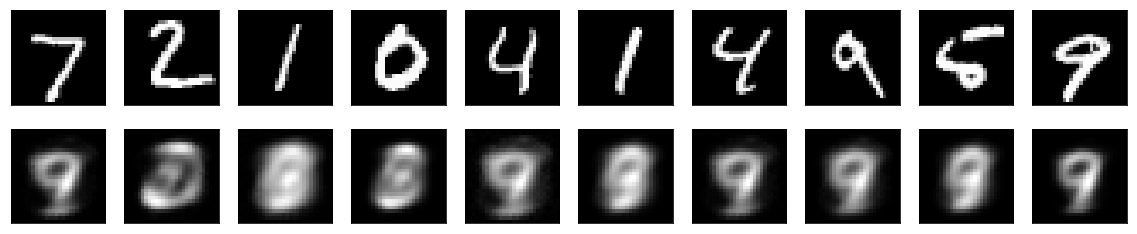

Imagenes para d' = 8


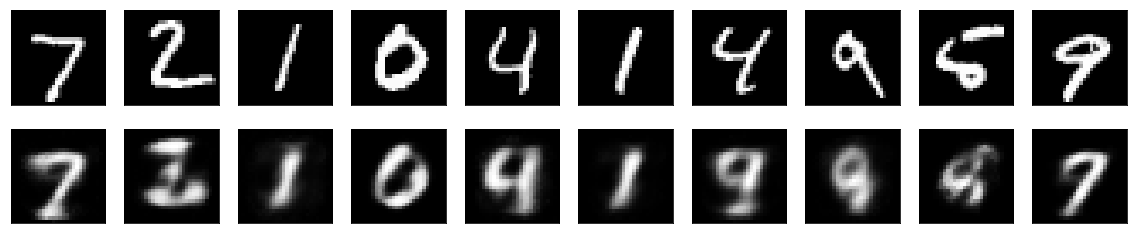

Imagenes para d' = 32


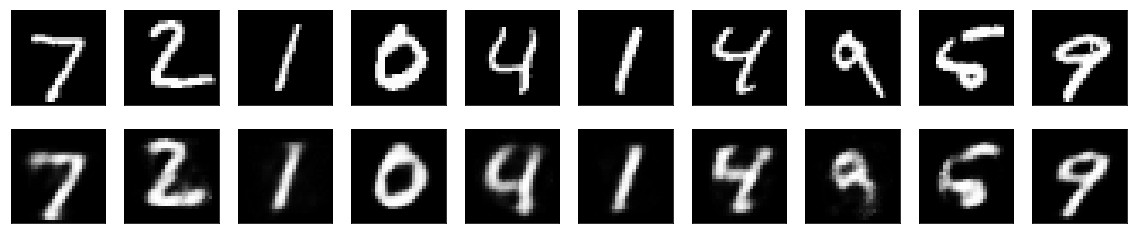

Imagenes para d' = 64


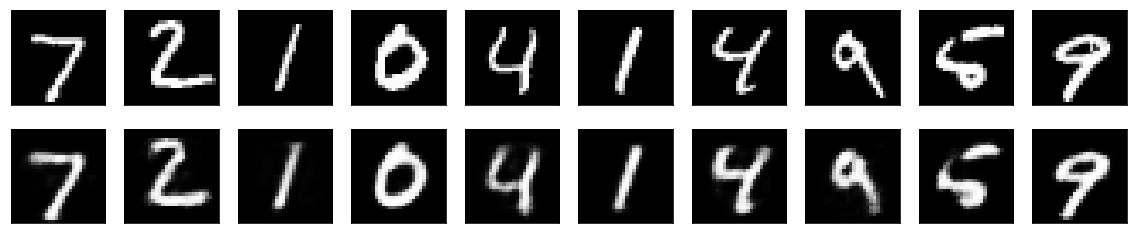

In [22]:
warnings.filterwarnings('ignore')

# Funciones de activación de encoder y decoder
encoder_act_function = 'relu'
decoder_act_function = 'sigmoid'
n = 10 # Cantidad de imágenes a estudiar por cada d'

for dimension in dimensions:
    
    print "Imagenes para d' = " + str(dimension)
    
    autoencoder = autoencoders['autoencoder_784x' + str(dimension)]
    decoded_test = autoencoder.predict(x_test)
    
    plt.figure(figsize=(20, 4))
    
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

Las imágenes hablan por si solas: A medida que la cantidad de dimensiones de la nueva representación aumenta, la calidad de las reconstrucciones también lo hace. Esto es consistente con los errores de reconstrucción calculados previamente, ya que estos disminuyeron al aumentar la cantidad de dimensiones de la nueva representación.

**3.1.3 Clasificación de dígitos por medio de kNN**

Con el fin de determinar la calidad de la compresión realizada por un autoencoder, se implementará un clasificador kNN para posteriormente evaluarlo sobre el conjunto de pruebas. En primer lugar, dicho clasificador es entrenado a partir de los ejemplos originales contenidos en el conjunto de entrenamiento (sin compresión) para efectos comparativos. Para el modelo, se utilizará k = 10.

In [4]:
# Se crea clasificador kNN, con k = 10
clf_original = KNeighborsClassifier(10)
# Se entrena clasificador a partir de ejemplos sin compresión
clf_original.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

A continuación, se determina el error que se obtiene al evaluar el modelo sobre el conjunto de pruebas, junto con el tiempo medio necesario para la clase de ejemplo perteneciente a este set de datos.

In [7]:
t_i = time.time()
print 'Error de clasificacion sobre conjunto de pruebas luego de entrenar sobre ejemplos sin compresion: ', \
    (1 - clf_original.score(x_test, y_test)) * 100, ' %'
t_f = time.time()
print 'Tiempo medio de prediccion: ', (t_f - t_i) / len(x_test), '[s]'

Error de clasificacion sobre conjunto de pruebas luego de entrenar sobre ejemplos sin compresion:  7.49  %
Tiempo medio de prediccion:  0.0237389283895 [s]


Se observa entonces que el error de clasificación es de un 7,49%, mientras que el tiempo medio de predicción fue de 0,024 [s] por ejemplo, durando 240 [s] el proceso completo.

Con estas métricas en mente, se procede a implementar otro clasificador kNN, nuevamente con k = 10, pero entrenándolo a partir de los ejemplos comprimidos. Se utilizará una compresión d' = 2, 4, 8, 16, 32, y funciones de activación ReLU y sigmoide para el encoder y el decoder, respectivamente, dados los buenos resultados obtenidos para este modelo en las secciones previas.

Se implementará, además, un enconder por separado, para cada d' posible, pues en este punto no se requiere utilizar un decoder.

In [8]:
warnings.filterwarnings('ignore')
input_img = Input(shape=(784, ))

for dimension in [2, 4, 8, 16, 32, 64]:
    
    print "d' = ", dimension
    
    # Se implementa encoder por separado
    encoded = Dense(dimension, activation='relu')(input_img)
    encoder = Model(input_img, output=encoded)
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    
    # Se crea clasificador kNN, con k = 10
    clf_compressed = KNeighborsClassifier(10)
    # Se entrena clasificador a partir de ejemplos comprimidos
    clf_compressed.fit(encoded_train, y_train)
    
    t_i = time.time()
    print "Error de clasificacion sobre conjunto de pruebas: ", \
    (1 - clf_compressed.score(encoded_test, y_test)) * 100, ' %'
    t_f = time.time()
    print 'Tiempo medio de prediccion: ', (t_f - t_i) / len(x_test), '[s]\n'

d' =  2
Error de clasificacion sobre conjunto de pruebas:  82.26  %
Tiempo medio de prediccion:  1.09549045563e-05 [s]

d' =  4
Error de clasificacion sobre conjunto de pruebas:  72.67  %
Tiempo medio de prediccion:  9.47258472443e-06 [s]

d' =  8
Error de clasificacion sobre conjunto de pruebas:  55.56  %
Tiempo medio de prediccion:  3.13601016998e-05 [s]

d' =  16
Error de clasificacion sobre conjunto de pruebas:  43.18  %
Tiempo medio de prediccion:  0.00010530591011 [s]

d' =  32
Error de clasificacion sobre conjunto de pruebas:  25.25  %
Tiempo medio de prediccion:  0.000315763020515 [s]

d' =  64
Error de clasificacion sobre conjunto de pruebas:  16.13  %
Tiempo medio de prediccion:  0.000719285702705 [s]



Se observa como, al aumentar la compresión, el error de clasificación disminuye, al igual que el tiempo promedio de clasificación.

Desafortunadamente, el error más bajo obtenido al comprimir los datos (para d' = 64), es de un 16,13%, ósea, es superior en un 8,64% al error obtenido sobre los datos sin compresión. Sin embargo, el tiempo promedio de clasificación disminuye notablemente a 0,0007 [s] por ejemplo, lo que en suma entrega un tiempo total de predicción de 7 [s].

Ante esta situación, se puede decir que efectivamente la comprensión permitió la predicción de las clases de cada ejemplo de forma mucho más eficiente en términos de tiempo, pero resultan ser compresiones quizás demasiado altas como para que el modelo sea capaz de generar buenas predicciones a partir de los ejemplos modificados.

**3.1.4 Comparación de efectos de reducción de dimensionalidad con PCA**

En esta sección, los ejemplos serán comprimidos por medio de la técnica de reducción de dimensionalidad PCA. Luego, se realizarán predicciones y los resultados serán comparados con aquellos obtenidos al reducir la dimensionalidad de los datos por medio de autoencoders. Como métricas de comparación, se considerarán el error de reducción y el error de clasificación por medio de kNN.

In [14]:
warnings.filterwarnings('ignore')

for dimension in [2, 4, 8, 16, 32, 64]:
    
    print "d' = ", dimension
    
    # Se define nivel de compresión, vía PCA
    pca = PCA(n_components=dimension)
    
    # Se realiza reducción de dimensionalidad para conjuntos de entrenamiento y de prueba
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    
    # Se determina error de reconstrucción
    #Primero, se estiman las componentes
    U, S, VT = np.linalg.svd(x_test - x_test.mean(0))
    # Después, se calculan las cargas
    pca_train_2 = (x_test - pca.mean_).dot(pca.components_.T)
    # Luego, se obtienen las proyecciones sobre las componentes principales
    x_projected = pca.inverse_transform(pca_test)
    x_projected_2 = pca_test.dot(pca.components_) +pca.mean_
    # Finalmente, se calcula error de reconstrucción
    reconstruction_error = ((x_test - x_projected) ** 2).mean()
    
    # Se crea clasificador kNN, con k = 10
    clf_pca = KNeighborsClassifier(10)
    # Se entrena clasificador a partir de ejemplos comprimidos
    clf_pca.fit(pca_train, y_train)
    
    print "Error de reconstruccion: ", reconstruction_error
    print "Error de clasificacion sobre conjunto de pruebas: ", \
    (1 - clf_pca.score(pca_test, y_test)) * 100, ' %\n'

d' =  2
Error de reconstruccion:  0.0555464589765
Error de clasificacion sobre conjunto de pruebas:  56.1  %

d' =  4
Error de reconstruccion:  0.0478027744412
Error de clasificacion sobre conjunto de pruebas:  34.5  %

d' =  8
Error de reconstruccion:  0.0374364073754
Error de clasificacion sobre conjunto de pruebas:  12.39  %

d' =  16
Error de reconstruccion:  0.026818733527
Error de clasificacion sobre conjunto de pruebas:  6.67  %

d' =  32
Error de reconstruccion:  0.0168441006868
Error de clasificacion sobre conjunto de pruebas:  5.76  %

d' =  64
Error de reconstruccion:  0.00897680423945
Error de clasificacion sobre conjunto de pruebas:  6.23  %



En general, los errores de reconstrucción obtenidos son más bajos que los de los autoencoders, independiente del nivel de compresión empleado. Por otra parte, los errores de clasificación son considerablemente más bajos. Por ejemplo, para d' = 2, el error de clasificación obtenido a partir del uso de un autoencoder es de un 82,26%, mientras que con PCA el error es un 34,5%. Para ambos reductores de dimensionalidad, el error de clasificación más bajo es conseguido con d' = 64, pero para el autoencoder es de un 16,13%, mientras que para PCA es de un 6,23%.

**3.1.5 Implementación de *deep autoencoder* (deep AE)**